In [ ]:
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError

In [ ]:
from xml.dom.minidom import parse
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
import pickle
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn
from skimage.transform import resize
from skimage.feature import hog
import pickle

In [ ]:
# Define HOG parameters
winSize = (256, 256)
blockSize = (32, 32)
blockStride = (16, 16)
cellSize = (16, 16)
nbins = 9
orientations = 9

In [ ]:
!mkdir -p /kaggle/working/dataset/helmet
!mkdir -p /kaggle/working/dataset/non-helmet

In [ ]:
def extract_xml_data(file_path, xml_filename):
    label_path = file_path + '/' + xml_filename + '.xml'
    img_path = '/kaggle/input/hard-hat-detection/images' + '/' + xml_filename + '.png'
    domOBJ = parse(label_path)
    root = domOBJ.documentElement
    objects = root.getElementsByTagName("object")

    # for each identified and labelled object in the image, sort it and save it
    for idx, obj in enumerate(objects):
        cls_name = obj.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(obj.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(obj.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(obj.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(obj.getElementsByTagName("ymax")[0].childNodes[0].data)
        image = cv2.imread(img_path)
#         plt.imshow(image)
        cropped_image = image[y1:y2, x1:x2]
        try:
            cropped_image = cv2.resize(cropped_image, winSize)
        except:
            continue
#         plt.imshow(cropped_image)
        if cls_name == 'helmet':
            cv2.imwrite('/kaggle/working/dataset/helmet/' + xml_filename + f'_{idx}.png', cropped_image)
        else:
            cv2.imwrite('/kaggle/working/dataset/non-helmet/' + xml_filename + f'_{idx}.png', cropped_image)

In [47]:
files = os.listdir('/kaggle/input/hard-hat-detection/annotations')
# files = files[:1000]
for file in files:
    file_xml = file.split(".")
    extract_xml_data('/kaggle/input/hard-hat-detection/annotations', file_xml[0])

KeyboardInterrupt: 

In [ ]:
label2id = {'non-helmet':1, 'helmet': 0}

In [ ]:
HOG_Features = []
labels = []
datasetPath = '/kaggle/working/dataset/'
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

for label in list(label2id.keys()):
    print(label)
    if label == 'helmet':
        images = os.listdir(datasetPath + label + '/')
        for image in images[:len(labels)]:
            img = cv2.imread(datasetPath + label + '/' + image)
            features = hog.compute(img)
            HOG_Features.append(features.flatten())
            labels.append(label2id[label])
    else:
        images = os.listdir(datasetPath + label + '/')
        for image in images:
            img = cv2.imread(datasetPath + label + '/' + image)
            features = hog.compute(img)
            HOG_Features.append(features.flatten())
            labels.append(label2id[label])
    
HOG_Features = np.array(HOG_Features, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(HOG_Features, labels, test_size=0.2, random_state=1789, shuffle=True)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

In [ ]:
print("score on training set params: ", clf.score(X_train, y_train))

In [ ]:
print("score on testing set params: ", clf.score(X_test, y_test))

In [ ]:
pickle.dump(clf, open('svm_classifier.pkl', 'wb'))

In [ ]:
# load the model
clf = pickle.load(open('/kaggle/input/500-helmet-hog-image-svm-classifier/svm_classifier.pkl', 'rb'))

## Uploading a test image

### Without Helmet test case

In [ ]:
testImage = cv2.imread('/kaggle/input/helmet-test-images/jimit_shah.jpg')

In [ ]:
testImage = cv2.resize(testImage, (512, 512))

In [ ]:
testImage.shape

### Apply Sliding window with different scales to get potential bounding boxes - apply classifier to those boxes to check if helmet or not

In [ ]:
def sliding_window(image, stepSize, windowSize):
    windows = []
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            windows.append((x, y, image[y:y + windowSize[1], x:x + windowSize[0]]))
    return windows

In [ ]:
def checkForHelmet(hog, window):
    if len(window) > 2:
        try:
            features = hog.compute(window[2])
        except:
            return False
        if len(features) != 0:
            features = features.flatten()
            try:
                pred = clf.predict([features])
            except:
                return False
    #         print("Pred:", pred)
            if pred[0] == 0:
                return True
            else:
                return False
        else:
            return False
    else:
        return False

In [ ]:
windows = sliding_window(testImage, 32, winSize)
print(len(windows))
# plt.imshow(windows[38][2])

In [ ]:
foundCandidates = []
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
for window in windows[:30]:
    if checkForHelmet(hog, window):
        foundCandidates.append(window[2])

In [ ]:
print(len(foundCandidates))

In [ ]:
count = len(foundCandidates)
rows = 0
if count >= 6:
    rows = count // 6
else:
    rows = count
_, axs = plt.subplots(rows, 6, figsize=(8, 8))
axs = axs.flatten()
    
for img, ax in zip(foundCandidates, axs):
    ax.imshow(img)

plt.show()

### With helmet test image

In [ ]:
testImage = cv2.imread('/kaggle/input/helmet-test-images/yash_seth.jpg')

In [ ]:
testImage = cv2.resize(testImage, (512, 512))

In [ ]:
testImage.shape

In [ ]:
windows = sliding_window(testImage, 32, [256, 256])
print(len(windows))

In [ ]:
foundCandidates = []
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
for window in windows[:40]:
    if checkForHelmet(hog, window):
        foundCandidates.append(window[2])

In [ ]:
print(len(foundCandidates))

In [ ]:
count = len(foundCandidates)
rows = 0
if count >= 6:
    rows = count // 6
else:
    rows = count
_, axs = plt.subplots(rows, 6, figsize=(8, 8))
axs = axs.flatten()
    
for img, ax in zip(foundCandidates, axs):
    ax.imshow(img)

plt.show()

## Fresh Attempt

In [3]:
import os
import cv2
import argparse
from sklearn.svm import LinearSVC
from skimage import feature
from sklearn.model_selection import train_test_split
import numpy as np
from xml.dom.minidom import parse
import matplotlib.pyplot as plt
import pickle

In [49]:
!mkdir -p /kaggle/working/dataset/helmet
!mkdir -p /kaggle/working/dataset/non-helmet

### Colour Transformations Helpers

In [50]:
def histogramEqualization(img_path, filename):
    img = cv2.imread(img_path, 0) 
    equ = cv2.equalizeHist(img)
    cv2.imwrite("./Transformations/HistogramEqualization/" + filename, equ) 

def gammaCorrection(img_path, filename):
    img = cv2.imread(img_path, 0) 
    gamma_corrected = np.array(255*(img / 255) ** 1.2, dtype = 'uint8') 
    cv2.imwrite("./Transformations/GammaCorrected/" + filename, gamma_corrected) 

def gaussianBlurring(img_path, filename):
    img = cv2.imread(img_path, 0) 
    Gaussian = cv2.GaussianBlur(img, (7, 7), 0) 
    cv2.imwrite("./Transformations/GaussianBlurred/" + filename, Gaussian) 

def normalizeRed(intensity):
    iI      = intensity
    minI    = 86
    maxI    = 230
    minO    = 0
    maxO    = 255
    iO      = (iI-minI)*(((maxO-minO)/(maxI-minI))+minO)
    return iO

def normalizeGreen(intensity):
    iI      = intensity  
    minI    = 90
    maxI    = 225 
    minO    = 0
    maxO    = 255 
    iO      = (iI-minI)*(((maxO-minO)/(maxI-minI))+minO)
    return iO

# Method to process the blue band of the image

def normalizeBlue(intensity):
    iI      = intensity   
    minI    = 100
    maxI    = 210
    minO    = 0
    maxO    = 255
    iO      = (iI-minI)*(((maxO-minO)/(maxI-minI))+minO)
    return iO


def contrastStetching(img_path, filename):
    # Create an image object
    imageObject     = Image.open(img_path)    
    # Split the red, green and blue bands from the Image
    multiBands      = imageObject.split()
   
    # Apply point operations that does contrast stretching on each color band
    normalizedRedBand      = multiBands[0].point(normalizeRed)
    normalizedGreenBand    = multiBands[1].point(normalizeGreen)
    normalizedBlueBand     = multiBands[2].point(normalizeBlue)
   
    # Create a new image from the contrast stretched red, green and blue brands
    normalizedImage = Image.merge("RGB", (normalizedRedBand, normalizedGreenBand, normalizedBlueBand))
    normalizedImage.save("./Transformations/ContrastStretched/" + filename) 

In [51]:
def extract_xml_data(file_path, xml_filename):
    label_path = file_path + '/' + xml_filename + '.xml'
    img_path = '/kaggle/input/hard-hat-detection/images' + '/' + xml_filename + '.png'
    domOBJ = parse(label_path)
    root = domOBJ.documentElement
    objects = root.getElementsByTagName("object")

    # for each identified and labelled object in the image, sort it and save it
    for idx, obj in enumerate(objects):
        cls_name = obj.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(obj.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(obj.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(obj.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(obj.getElementsByTagName("ymax")[0].childNodes[0].data)
        image = cv2.imread(img_path)
        cropped_image = image[y1:y2, x1:x2]
        try:
            cropped_image = cv2.resize(cropped_image, (64, 128))
        except:
            continue
        
        colour_transformations = ['original', 'histogram equalization', 'gamma correction', 'gaussian blurring']
        for transform in colour_transformations:
            if transform == 'original':
                if cls_name == 'helmet':
                    cv2.imwrite('/kaggle/working/dataset/helmet/' + xml_filename + f'_{idx}.png', cropped_image)
                else:
                    cv2.imwrite('/kaggle/working/dataset/non-helmet/' + xml_filename + f'_{idx}.png', cropped_image)  
            elif transform == 'histogram equalization':
                gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY) 
                equ = cv2.equalizeHist(gray_image)
                if cls_name == 'helmet':
                    cv2.imwrite('/kaggle/working/dataset/helmet/' + xml_filename + f'_{idx}_HE.png', equ)
                else:
                    cv2.imwrite('/kaggle/working/dataset/non-helmet/' + xml_filename + f'_{idx}_HE.png', equ)
                
            elif transform == 'gamma correction':
                gamma_corrected = np.array(255*(cropped_image / 255) ** 1.2, dtype = 'uint8')
                if cls_name == 'helmet':
                    cv2.imwrite('/kaggle/working/dataset/helmet/' + xml_filename + f'_{idx}_GC.png', gamma_corrected)
                else:
                    cv2.imwrite('/kaggle/working/dataset/non-helmet/' + xml_filename + f'_{idx}_GC.png', gamma_corrected)
                
            elif transform == 'gaussian blurring':
                Gaussian = cv2.GaussianBlur(cropped_image, (7, 7), 0) 
                if cls_name == 'helmet':
                    cv2.imwrite('/kaggle/working/dataset/helmet/' + xml_filename + f'_{idx}_GB.png', Gaussian)
                else:
                    cv2.imwrite('/kaggle/working/dataset/non-helmet/' + xml_filename + f'_{idx}_GB.png', Gaussian)

In [52]:
files = os.listdir('/kaggle/input/hard-hat-detection/annotations')
# files = files[:1000]
for file in files:
    file_xml = file.split(".")
    extract_xml_data('/kaggle/input/hard-hat-detection/annotations', file_xml[0])

In [53]:
# get total number of non-helmet instances
datasetPath = '/kaggle/working/dataset/'
nonHelmetImages = os.listdir(datasetPath + 'non-helmet' + '/')
sampleLimit = len(nonHelmetImages)
print(sampleLimit)

26144


In [54]:
datasetPath = '/kaggle/working/dataset/'
images = []
labels = []

helmetImages = os.listdir(datasetPath + 'helmet' + '/')
for image in helmetImages[:sampleLimit]:
    img = cv2.imread(datasetPath + 'helmet' + '/' + image)
    hog_desc = feature.hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys', channel_axis=2)
    images.append(hog_desc)
    labels.append(0)
   
nonHelmetImages = os.listdir(datasetPath + 'non-helmet' + '/')
for image in nonHelmetImages[:sampleLimit]:
    img = cv2.imread(datasetPath + 'non-helmet' + '/' + image)
    hog_desc = feature.hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys', channel_axis=2)
    images.append(hog_desc)
    labels.append(1)

In [55]:
len(images)

52288

In [56]:
# should be (3780, 0) according to HOG research paper as per the block and sub-block size set
images[0].shape

(3780,)

In [57]:
id2label = {0:'helmet', 1:'non-helmet'}

In [58]:
len(images)

52288

In [59]:
print(labels.count(0))

26144


In [60]:
print(labels.count(1))

26144


In [1]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=1789, shuffle=True)

NameError: name 'train_test_split' is not defined

In [62]:
X_train[0].shape

(3780,)

### Classification Approach

In [ ]:
svm_model = LinearSVC(random_state=1789, tol=1e-5, probability=True)
svm_model.fit(X_train, y_train)

In [92]:
print("score on training set params: ", svm_model.score(X_train, y_train))

score on training set params:  0.8803490024998775


In [93]:
print("score on testing set params: ", svm_model.score(X_test, y_test))

score on testing set params:  0.7947461282101549


### Probability Approach

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(X_train, y_train)

In [ ]:
print("score on training set params: ", clf.score(X_train, y_train))

In [ ]:
print("score on testing set params: ", clf.score(X_test, y_test))

In [ ]:
import pickle
pickle.dump(clf, open('CT_5000.pkl', 'wb'))

### Trying on test image

In [17]:
image = cv2.imread('/kaggle/input/helmet-test-images/rahul_singh.jpg', )
height, width = image.shape[:2] 
print(height, width)

318 374


In [18]:
# get class probability values
hog_desc = feature.hog(image[0:128, 0:64], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys', channel_axis=2)
prob_vec = clf.predict_proba([hog_desc])
print(prob_vec)

[[0.72778895 0.27221105]]


In [19]:
log_prob_vec = clf.predict_log_proba([hog_desc])
print(log_prob_vec)

[[-0.31774418 -1.30117759]]


In [27]:
# using probability approach
# required window shape = (64, 128)

clf = pickle.load(open('/kaggle/input/colour-transformation-on-1000-images-svm-model/CT_1000.pkl', 'rb'))
image = cv2.imread('/kaggle/input/helmet-test-images/rahul_singh.jpg')

image = cv2.resize(image, (318, 374))
height, width = image.shape[:2] 

found_location = []


for x in range(0, width - 64, 12):
    for y in range(0, height - 128, 16):
        currWindowImg = image[y:y+128, x:x+64]
#         print(currWindowImg.shape)
#         plt.imshow(currWindowImg)
        hog_desc = feature.hog(currWindowImg, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys', channel_axis=2)
        prob_vec = clf.predict_proba([hog_desc])
        if prob_vec[0][1] >= 0.90:
            found_location.append([[x,y], [x+64,y+128]])

# image pyramid version
# for i in range(0, 2, 1):
#     for x in range(0, width - 64, 12):
#         for y in range(0, height - 128, 12):
#             currWindowImg = image[y:y+128, x:x+64]
#     #         print(currWindowImg.shape)
#     #         plt.imshow(currWindowImg)
#             hog_desc = feature.hog(currWindowImg, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys', channel_axis=2)
#             prob_vec = clf.predict_proba([hog_desc])
#             if prob_vec[0][0] >= 0.90:
#                 found_location.append([[x,y], [x+64,y+128]])
#     image = cv2.pyrDown(image) 

In [28]:
print(len(found_location))

30


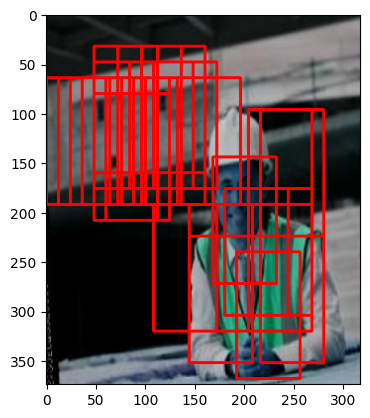

In [29]:
for loc in found_location:
    cv2.rectangle(image, loc[0], loc[1], (255,0,0), 2)

plt.imshow(image)

In [107]:
# using classification approach
# required window shape = (64, 128)

image = cv2.imread('/kaggle/input/helmet-test-images/rahul_singh.jpg')
height, width = image.shape[:2] 

helmetFlag = False
preds = []

for x in range(0, width - 64, 12):
    for y in range(0, height - 128, 24):
        currWindowImg = image[y:y+128, x:x+64]
#         print(currWindowImg.shape)
#         plt.imshow(currWindowImg)
        hog_desc = feature.hog(currWindowImg, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys', channel_axis=2)
        pred = svm_model.predict([hog_desc])
        preds.append(pred[0])
#         if pred[0] == 0:
#             helmetFlag = True
#             break
#     if helmetFlag:
#         break

# if helmetFlag:
#     print("Helmet Found")

In [25]:
print("Non-helmet count:", preds.count(1))

Non-helmet count: 0


In [26]:
print("Helmet count:", preds.count(0))

Helmet count: 0


In [ ]:
image = cv2.imread(f"test_images/{args['path']}/{imagePath}")
resized_image = cv2.resize(image, (128, 256))

# get the HOG descriptor for the test image
(hog_desc, hog_image) = feature.hog(resized_image, orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys', visualize=True)
# prediction
pred = svm_model.predict(hog_desc.reshape(1, -1))[0]
# convert the HOG image to appropriate data type. We do...
# ... this instead of rescaling the pixels from 0. to 255.
hog_image = hog_image.astype('float64')
# show thw HOG image
cv2.imshow('HOG Image', hog_image)
# put the predicted text on the test image
cv2.putText(image, pred.title(), (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0,
    (0, 255, 0), 2)
cv2.imshow('Test Image', image)
cv2.imwrite(f"outputs/{args['path']}_hog_{i}.jpg", hog_image*255.) # multiply by 255. to bring to OpenCV pixel range
cv2.imwrite(f"outputs/{args['path']}_pred_{i}.jpg", image)
cv2.waitKey(0)